In [186]:
import numpy as np
import pandas as pd
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
from scipy.signal import savgol_filter as savgol

In [309]:
datadir = 'Exps/isovisc-misc-disp/beta70/Exp4_Re703/scaled_images.mat'
scaled_images = sio.loadmat(datadir)
scaled_images = scaled_images['scaled_im_cam0']
# the first dimension is number of pixels in spanwise, second dim is number of pixels in 
# streamwise dir, and third dim is number of snapshots


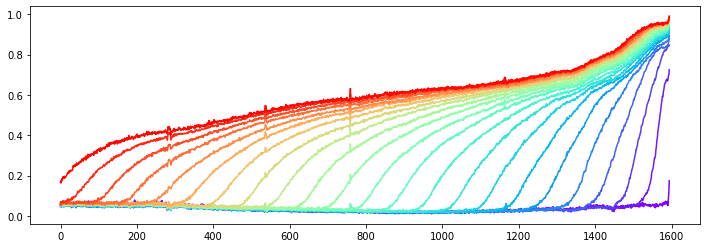

In [317]:
# average in spanwise direction for plotting to check for anomalies
span_avg_images = np.mean(scaled_images,axis=0)
window_size,polyorder=3,1
span_avg_images = savgol(span_avg_images,window_size,polyorder,axis=1)

# cmap stuff
n_lines = span_avg_images.shape[1] 
c = np.arange(1, n_lines + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.rainbow)
cmap.set_array([])

# use this figure to check if the some pixels in the x-dir need to be removed 
# or if some timepoints need to be removed
plt.figure(figsize=(12,4));
for tt in range(0,span_avg_images.shape[1],5): # plotting the avg conc for all time in each x
    plt.plot(span_avg_images[:-5,tt],c=cmap.to_rgba(tt));

# beta0/Exp30_Re703 has some artifact at the last few columns, removing them
data = scaled_images[:,:-5,:]
nY,nX,nT = scaled_images.shape

In [318]:
# snapshot matrix
X = scaled_images.reshape(nY*nX,nT)
Xp = X[:,0:-1]
Xf = X[:,1:]

In [319]:
# SVD enhanced DMD
U,s,Vh = np.linalg.svd(Xp)

dynamics truncated to rank r = 11


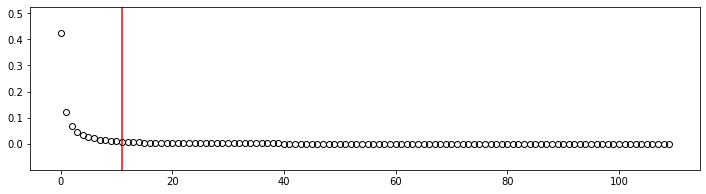

In [327]:
# r = np.minimum(U.shape[1],Vh.shape[0]) # this is the quick and dirty approach
sv_thresh = 0.01 # max normalized singular values are kept if greater than sv_thresh
s_var = s/s.sum()
r = np.max(np.nonzero((s_var > sv_thresh))[0]) + 1 

plt.figure(figsize=(12,3));
plt.plot(s_var,'o',mfc='None',mec='black');
plt.vlines(r,-10,1100,color='red');
plt.ylim(s_var.min()-0.1,s_var.max()+0.1);

print('dynamics truncated to rank r =',r)

In [328]:
U_r = U[:,0:r] # truncate to rank-r
s_r = s[0:r]
Vh_r = Vh[0:r,:]
Atilde = U_r.T @ Xf @ Vh_r.T @ np.diag(1/s_r) # low-rank dynamics

In [329]:
# eigendecomposition of Atilde
eVals,eVecs = np.linalg.eig(Atilde)
# DMD modes
Phi = Xf @ Vh_r.T @ np.diag(1/s_r) @ eVecs
Phi_real = np.real(Phi)

In [330]:
# define the energy content (or power) of the modes as λ_j^{nT−1}||mode_j||
Phi_power = eVals**(nT-1)*np.linalg.norm(Phi,ord=2,axis=0)
max_power_inds = np.absolute(Phi_power).argsort()[-r:][::-1]

In [331]:
max_power_inds

array([ 4,  6,  5,  8,  7, 10,  9,  3,  2,  1,  0])

In [332]:
def plot_eigvals(matrix):
    theta = np.linspace(0,20,100)
    L = np.linalg.eigvals(matrix)
    plt.figure();
    plt.plot(np.real(L),np.imag(L),'o');
    plt.plot(np.cos(theta),np.sin(theta),color='black',alpha=0.3)
    plt.axis('equal');

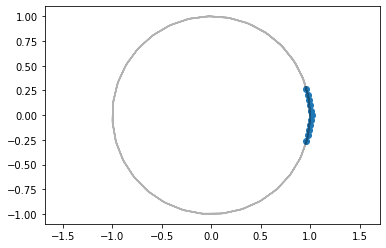

In [333]:
plot_eigvals(Atilde)

In [354]:
Phi_real_plot = Phi_real.reshape(nY,nX,r)
cont_eVals = list(np.round(np.log(eVals),3))
cont_eVals = [str(x) for x in cont_eVals]
plot_inds = [max_power_inds[0],max_power_inds[1],max_power_inds[3],max_power_inds[5],\
             max_power_inds[7],max_power_inds[9]]

In [364]:
cont_eVals[plot_inds[5]]

'(-0.004-0.265j)'

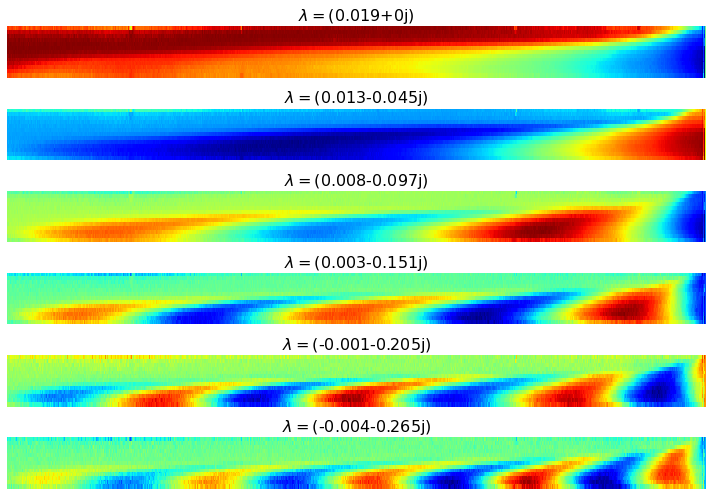

In [372]:
# fig,axs = plt.subplots(nrows=len(max_power_inds),ncols=1,figsize=(15,15))
fig,axs = plt.subplots(nrows=len(plot_inds),ncols=1,figsize=(10,7))
for ii,thisax in enumerate(axs.reshape(-1)):
    sb.heatmap(Phi_real_plot[:,:,plot_inds[ii]],cmap='jet',cbar=False,ax=thisax);
    thisax.set_title(r'$\lambda =$'+cont_eVals[plot_inds[ii]],fontsize=16)
    thisax.set_xticks([]);
    thisax.set_yticks([]);
plt.tight_layout();
plt.savefig('realmodes.pdf')

### Can the DMD modes explain the diffusion time-scale or coefficient? 